# SIAA: kNN

## Autores: Javier, Laura, Martín, Hugo, Raúl

En este notebook haremos un estudio paso por paso de los datos médicos de un grupo de mujeres.

Enlace del Dataset obtenido: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

#### Columnas de diabetes.csv:

**Pregnancies**
Número de veces embarazada


**Glucose**
Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia a la glucosa oral


**BloodPressure**
Presión arterial diastólica (mm Hg)


**SkinThickness**
Grosor del pliegue cutáneo del tríceps (mm)


**Insulin**
Insulina sérica a las 2 horas (mu U/ml)


**BMI**
Índice de masa corporal (peso en kg/(altura en m)^2)


**DiabetesPedigreeFunction**
Función de pedigrí de diabetes


**Age**
Edad (años)


**Outcome**
Variable de clase (0 o 1) 268 de 768 son 1, los demás son 0

Importamos todas las librerías necesarias

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [94]:
# Cargar el dataset
dataset = pd.read_csv('diabetes.csv', delimiter=',')

### Correlaciones:

Aqui mostramos los coeficientes de correlación de G3 con las demás columnas

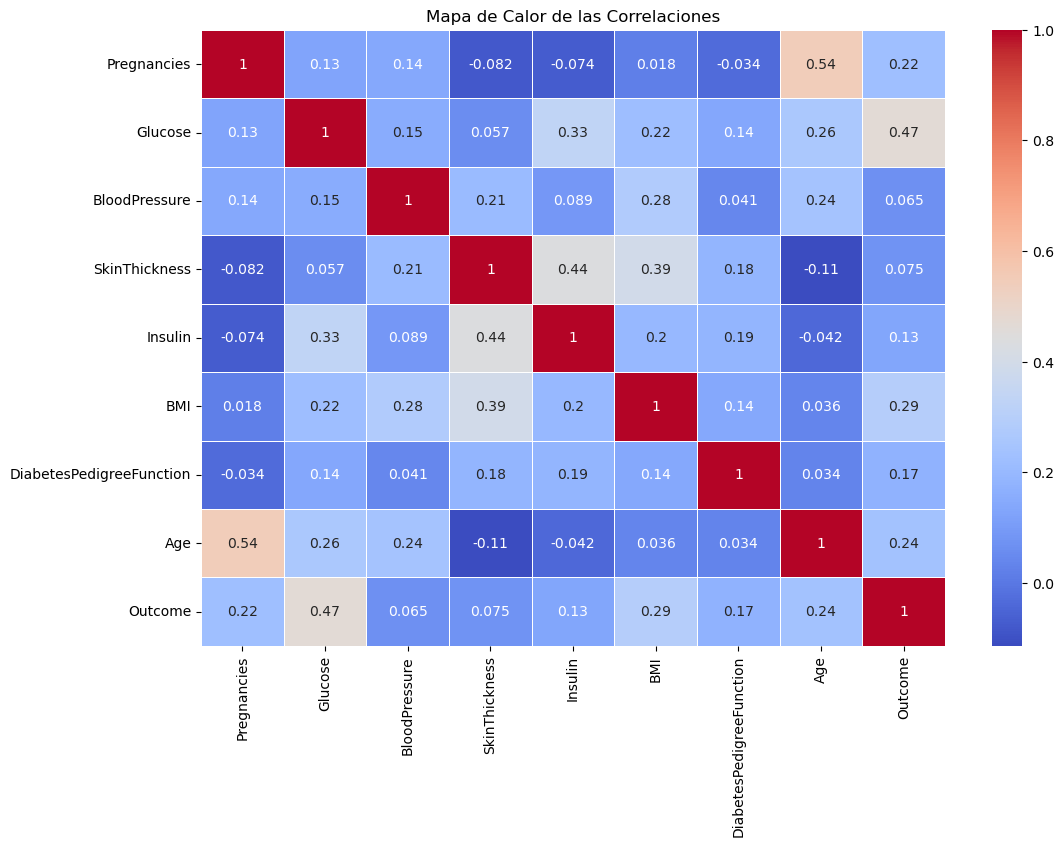

In [95]:
# Seleccionar las columnas para el modelo de regresión lineal: horas de estudio, edad, faltas, repeticiones, nota 1º, 2º y 3º evaluación
X = dataset[['Pregnancies', 'Glucose', 'BloodPressure',
             'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
Y = dataset['Outcome']

# Mostrar correlaciones
plt.figure(figsize=(12, 8))
correlation_matrix = dataset.corr()

# Generar el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de las Correlaciones')
plt.show()

Utilizando stratify = valor de y, aseguramos que la proporción de las clases en el conjunto de entrenamiento sea igual a la proporción de clases en el conjunto de prueba, si no, la división es aleatoria y puede que se escojan valores que no sean representativos de las proporciones en el conjunto original

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

# Utilizamos primero un número de vecinos estándar: 6
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

y_pred = knn.predict(X_test)


mse_knn = mean_squared_error(y_test, y_pred)
r2_knn = r2_score(y_test, y_pred)
print(f'kNN - MSE: {mse_knn}, R2: {r2_knn}')

kNN - MSE: 0.2857142857142857, R2: -0.2548148148148148


Buscamos un valor de k que sea más preciso y lo graficamos para verlo con más facilidad

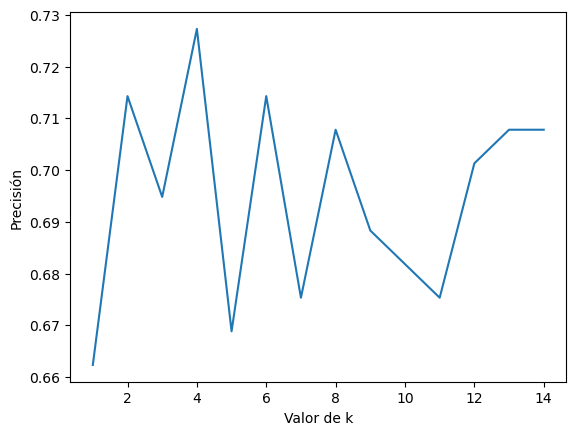

In [97]:
k_range = range(1, 15)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Valor de k')
plt.ylabel('Precisión')

plt.show()

In [98]:
# Ajustamos el número de vecinos al valor con mayor precisión y vemos como se reducen MSE y R2
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

y_pred = knn.predict(X_test)


mse_knn = mean_squared_error(y_test, y_pred)
r2_knn = r2_score(y_test, y_pred)
print(f'kNN - MSE: {mse_knn}, R2: {r2_knn}')

kNN - MSE: 0.2727272727272727, R2: -0.19777777777777783


In [ ]:
y_pred2 = knn.predict(X_test)
y_pred2

# podemos también usar predict_proba para tener las probabilidades de clase
probabilidades = knn.predict_proba(X_test)
print(probabilidades[:10])

[[0.   1.  ]
 [1.   0.  ]
 [0.75 0.25]
 [1.   0.  ]
 [1.   0.  ]
 [0.5  0.5 ]
 [0.25 0.75]
 [0.25 0.75]
 [1.   0.  ]
 [0.25 0.75]
 [0.75 0.25]
 [0.25 0.75]
 [1.   0.  ]
 [0.75 0.25]
 [0.75 0.25]
 [0.75 0.25]
 [0.   1.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.75 0.25]]


## Conclusiones:

- A

    ## Problemas encontrados:

        B